In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# --- Load data ---
con_df = pd.read_csv(r"E:\USA_PD_2024\Analysis\ppr6\COP\Data\Combine_Activity\Full\Controlled1.csv")
pd_df = pd.read_csv(r"E:\USA_PD_2024\Analysis\ppr6\COP\Data\Combine_Activity\Full\PD1.csv")

con_df["label"] = 0
pd_df["label"] = 1
df = pd.concat([con_df, pd_df], ignore_index=True)

# --- Extract SubjectID ---
def get_id(fname):
    base = Path(fname).stem
    m = re.search(r"_[a-zA-Z]*([0-9]+)", base)
    return m.group(1) if m else base

df["SubjectID"] = df["File"].apply(get_id)

# --- Prepare X, y, groups ---
X = df.drop(columns=["label", "File", "SubjectID"])
X = pd.get_dummies(X, columns=["Sex"], drop_first=True)
y = df["label"].values
groups = df["SubjectID"].values

# --- CV splitter ---
cv = GroupKFold(n_splits=5)

# --- Manual forward SFS function ---
def groupwise_sfs(pipe, X, y, groups):
    best_score = 0
    selected = []
    remaining = list(X.columns)
    while remaining:
        best_feat = None
        for feat in remaining:
            trial_feats = selected + [feat]
            fold_scores = []
            for tr, te in cv.split(X[trial_feats], y, groups):
                model = clone(pipe)
                model.fit(X[trial_feats].iloc[tr], y[tr])
                preds = model.predict(X[trial_feats].iloc[te])
                fold_scores.append(f1_score(y[te], preds))
            mean_score = np.mean(fold_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_feat = feat
        if best_feat:
            selected.append(best_feat)
            remaining.remove(best_feat)
        else:
            break
    return selected

# --- Define models and grids ---
models = [
    ("SVM (RBF)", Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", probability=True, random_state=42))]),
     {"clf__C": [0.1, 1, 10], "clf__gamma": ["scale", 0.1]}),

    ("Random Forest", Pipeline([("clf", RandomForestClassifier(random_state=42, n_jobs=-1))]),
     {"clf__n_estimators": [100], "clf__max_depth": [None]}),

    ("Logistic Regression", Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500, random_state=42))]),
     {"clf__C": [1]}),

    ("k-NN", Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())]),
     {"clf__n_neighbors": [5, 7]}),

    ("Gaussian NB", Pipeline([("clf", GaussianNB())]),
     {})
]

# --- Run each model with its own SFS ---
for name, pipe, param_grid in models:
    print(f"\n--- {name} Feature Selection ---")
    selected_feats = groupwise_sfs(pipe, X, y, groups)
    print(f"Selected features: {selected_feats}")

    X_sel = X[selected_feats]

    # GridSearchCV to find best parameters
    gs = GridSearchCV(pipe, param_grid, scoring="f1", cv=cv, n_jobs=-1)
    gs.fit(X_sel, y, groups=groups)
    best_est = gs.best_estimator_

    # Cross-validated evaluation
    accs, precs, recs, f1s, aucs = [], [], [], [], []
    for tr, te in cv.split(X_sel, y, groups):
        best_est.fit(X_sel.iloc[tr], y[tr])
        preds = best_est.predict(X_sel.iloc[te])
        probs = (best_est.predict_proba(X_sel.iloc[te])[:, 1]
                 if hasattr(best_est, "predict_proba")
                 else best_est.decision_function(X_sel.iloc[te]))

        accs.append(accuracy_score(y[te], preds))
        precs.append(precision_score(y[te], preds))
        recs.append(recall_score(y[te], preds))
        f1s.append(f1_score(y[te], preds))
        aucs.append(roc_auc_score(y[te], probs))

    print(f"=== {name} ===")
    print(f"Best params: {gs.best_params_}")
    print(f"Accuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
    print(f"Recall   : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
    print(f"F1-score : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"ROC-AUC  : {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")



--- SVM (RBF) Feature Selection ---
Selected features: ['Age', 'Feature_avg_centroid_frequency_Power_Spectrum_Density_ML', 'Feature_avg_phase_plane_parameter_ML', 'Feature_asym_energy_content_below_05_Power_Spectrum_Density_AP', 'Feature_asym_energy_content_05_2_Power_Spectrum_Density_AP']
=== SVM (RBF) ===
Best params: {'clf__C': 1, 'clf__gamma': 'scale'}
Accuracy : 0.913 ± 0.027
Precision: 0.927 ± 0.068
Recall   : 0.885 ± 0.043
F1-score : 0.903 ± 0.031
ROC-AUC  : 0.928 ± 0.046

--- Random Forest Feature Selection ---
Selected features: ['Feature_asym_energy_content_below_05_Power_Spectrum_Density_AP', 'Feature_asym_mean_value_ML', 'Feature_asym_frequency_quotient_Power_Spectrum_Density_ML', 'Age', 'Feature_avg_power_frequency_95_Power_Spectrum_Density_ML']
=== Random Forest ===
Best params: {'clf__max_depth': None, 'clf__n_estimators': 100}
Accuracy : 0.870 ± 0.067
Precision: 0.851 ± 0.109
Recall   : 0.885 ± 0.076
F1-score : 0.863 ± 0.069
ROC-AUC  : 0.897 ± 0.050

--- Logistic Regre


==================== SVM-RBF ====================
[Fold 1]  #sel=10 → ['Age', 'Feature_avg_rms_ML', 'Feature_avg_phase_plane_parameter_ML', 'Feature_asym_frequency_quotient_Power_Spectrum_Density_AP', 'Feature_avg_energy_content_05_2_Power_Spectrum_Density_ML', 'Feature_avg_critical_time_Diffusion_AP', 'Feature_asym_LFS_ML_AND_AP', 'Feature_avg_mean_frequency_AP', 'Feature_asym_zero_crossing_SPD_ML', 'Feature_avg_rms_Radius']
[Fold 2]  #sel=5 → ['Age', 'Feature_asym_short_time_scaling_Diffusion_ML', 'Feature_avg_fractal_dimension_ML_AND_AP', 'Feature_asym_range_ML_AND_AP', 'Height']
[Fold 3]  #sel=6 → ['Age', 'Feature_asym_range_AP', 'Sex_Male', 'Weight', 'Feature_avg_mean_value_ML', 'Height']
[Fold 4]  #sel=5 → ['Age', 'Height', 'Sex_Male', 'Feature_asym_maximal_distance_ML', 'Feature_asym_maximal_distance_AP']
[Fold 5]  #sel=7 → ['Age', 'Feature_asym_mean_distance_peak_Sway_Density', 'Feature_asym_maximal_distance_Radius', 'Feature_avg_energy_content_05_2_Power_Spectrum_Density_ML',

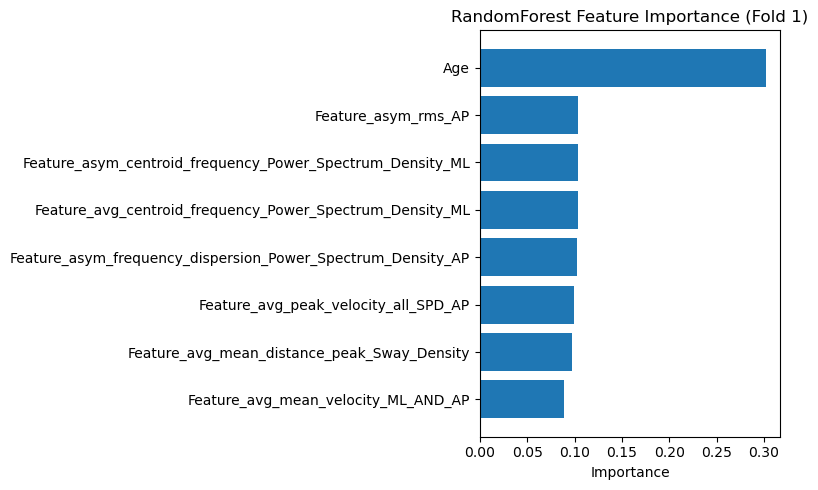

[Fold 2]  #sel=5 → ['Sex_Male', 'Age', 'Height', 'Feature_asym_mean_distance_peak_Sway_Density', 'Feature_asym_range_ratio_ML_AND_AP']


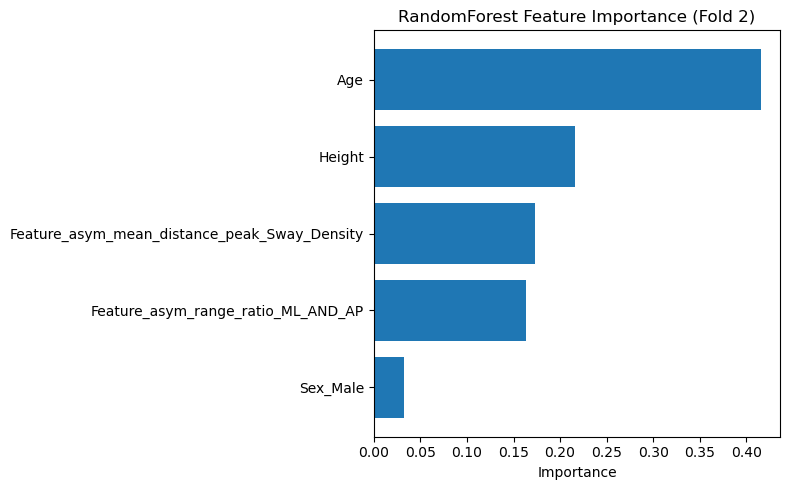

[Fold 3]  #sel=8 → ['Age', 'Feature_avg_mean_distance_ML', 'Feature_avg_mean_velocity_ML', 'Feature_avg_mean_velocity_AP', 'Feature_avg_range_ratio_ML_AND_AP', 'Feature_avg_maximal_distance_ML', 'Feature_avg_mean_frequency_ML_AND_AP', 'Feature_avg_power_frequency_50_Power_Spectrum_Density_ML']


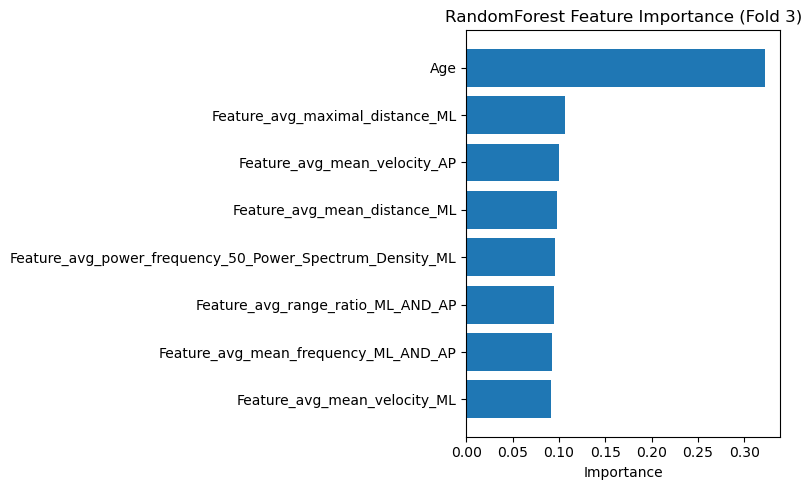

[Fold 4]  #sel=8 → ['Age', 'Height', 'Feature_asym_peak_velocity_all_SPD_ML', 'Feature_asym_mean_value_ML', 'Feature_asym_mean_frequency_AP', 'Feature_asym_rms_Radius', 'Feature_avg_mean_distance_Radius', 'Feature_avg_power_frequency_50_Power_Spectrum_Density_AP']


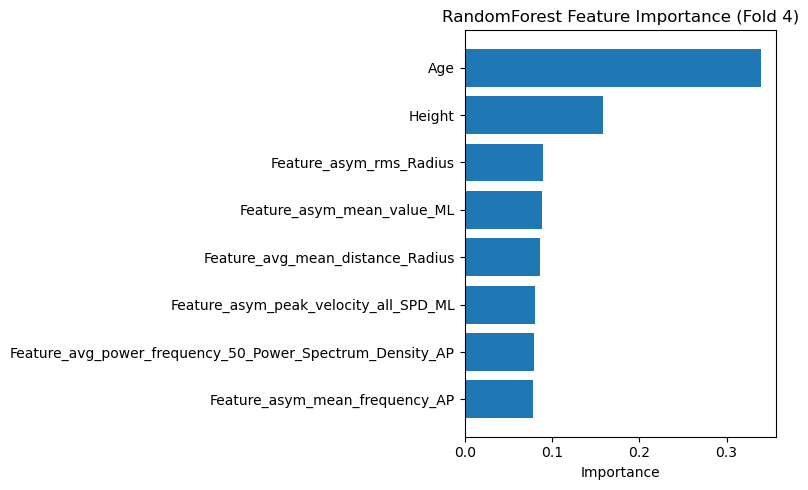

[Fold 5]  #sel=5 → ['Height', 'Feature_asym_short_time_diffusion_Diffusion_AP', 'Age', 'Sex_Male', 'Feature_asym_maximal_distance_ML']


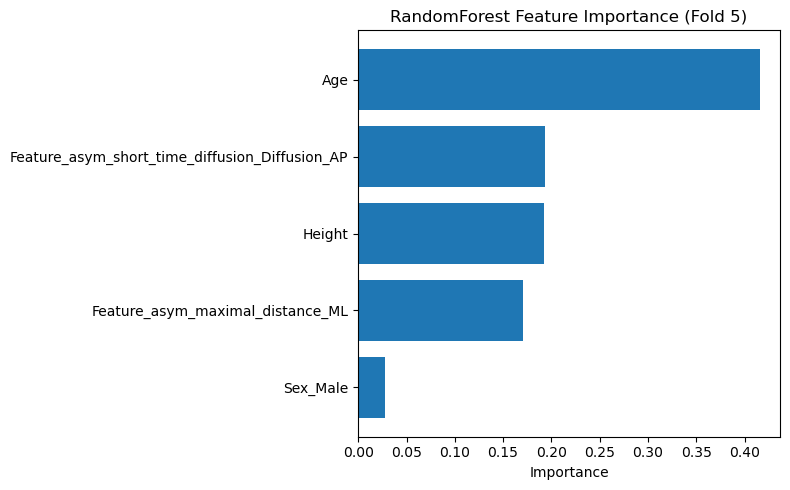


==================== LogReg ====================
[Fold 1]  #sel=5 → ['Age', 'Weight', 'Feature_asym_short_time_scaling_Diffusion_ML', 'Feature_asym_range_ratio_ML_AND_AP', 'Feature_asym_energy_content_below_05_Power_Spectrum_Density_ML']


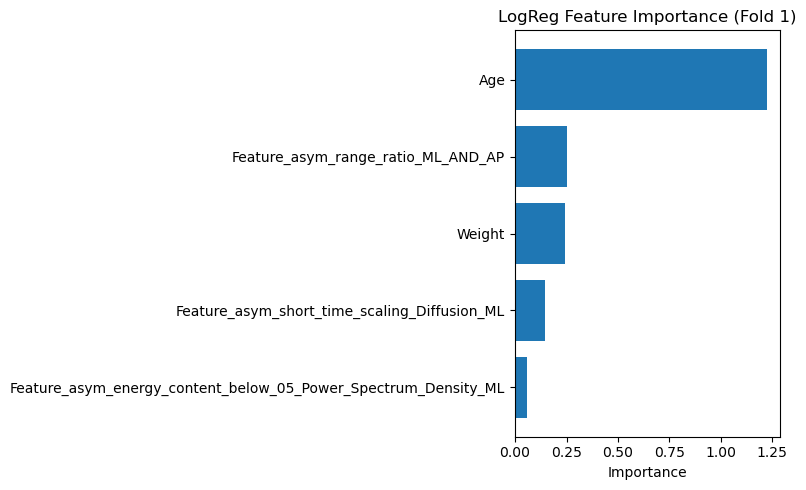

[Fold 2]  #sel=5 → ['Age', 'Feature_asym_long_time_scaling_Diffusion_AP', 'Height', 'Sex_Male', 'Feature_asym_mean_distance_peak_Sway_Density']


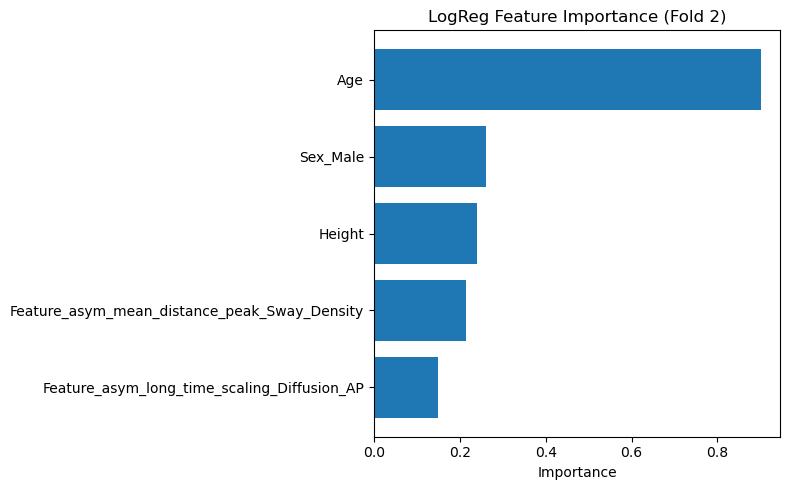

[Fold 3]  #sel=8 → ['Age', 'Weight', 'Feature_asym_mean_value_ML', 'Feature_avg_long_time_scaling_Diffusion_ML', 'Feature_asym_rms_Radius', 'Feature_avg_short_time_diffusion_Diffusion_AP', 'Feature_asym_mean_peak_Sway_Density', 'Feature_asym_short_time_scaling_Diffusion_ML']


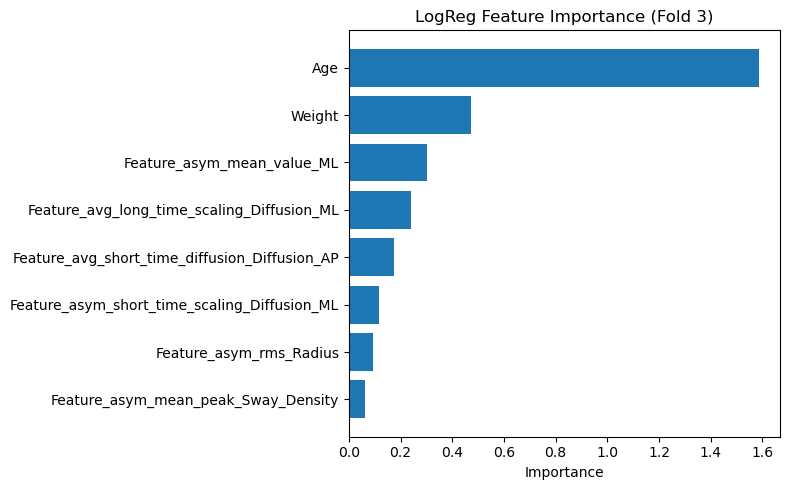

[Fold 4]  #sel=6 → ['Age', 'Feature_avg_maximal_distance_ML', 'Feature_avg_total_power_Power_Spectrum_Density_ML', 'Feature_asym_energy_content_05_2_Power_Spectrum_Density_ML', 'Feature_avg_power_frequency_50_Power_Spectrum_Density_ML', 'Feature_asym_energy_content_05_2_Power_Spectrum_Density_AP']


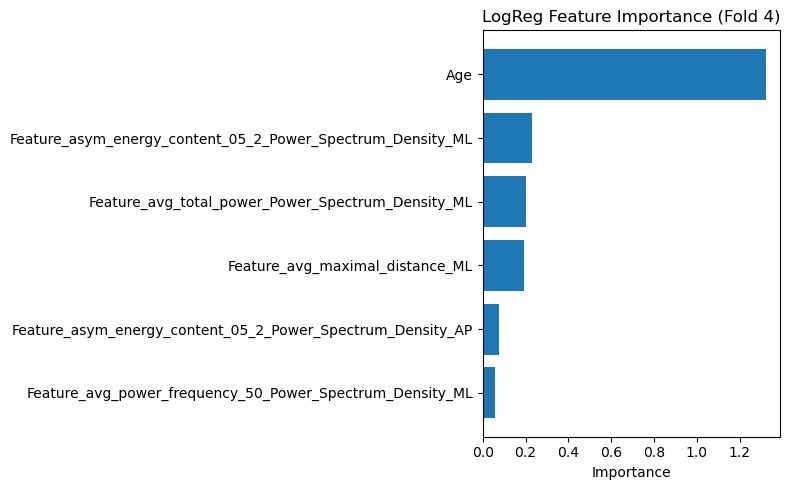

[Fold 5]  #sel=10 → ['Age', 'Feature_asym_range_ratio_ML_AND_AP', 'Feature_avg_frequency_quotient_Power_Spectrum_Density_ML', 'Feature_avg_maximal_distance_ML', 'Feature_asym_maximal_distance_Radius', 'Feature_avg_coefficient_sway_direction_ML_AND_AP', 'Feature_asym_maximal_distance_ML', 'Feature_asym_mean_distance_peak_Sway_Density', 'Feature_asym_mean_frequency_ML', 'Feature_avg_critical_time_Diffusion_AP']


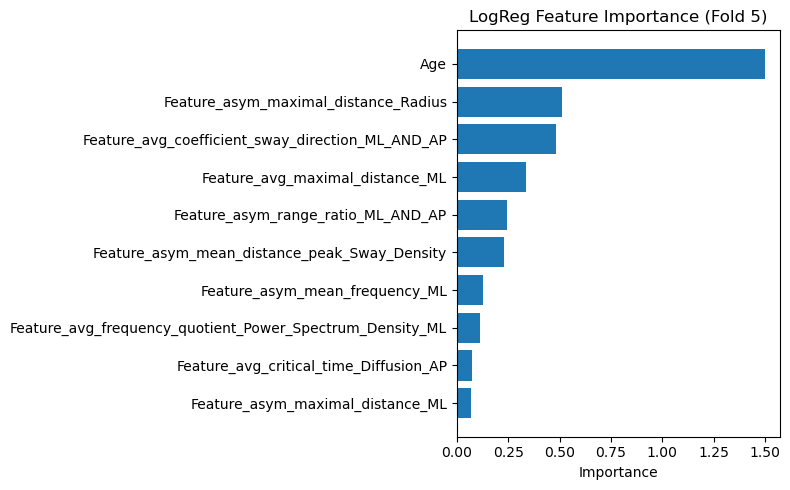


==================== kNN ====================
[Fold 1]  #sel=6 → ['Feature_asym_range_ratio_ML_AND_AP', 'Age', 'Feature_avg_mean_velocity_AP', 'Feature_avg_centroid_frequency_Power_Spectrum_Density_ML', 'Feature_avg_critical_time_Diffusion_ML', 'Feature_avg_critical_time_Diffusion_AP']
[Fold 2]  #sel=5 → ['Feature_asym_rms_AP', 'Age', 'Feature_asym_critical_displacement_Diffusion_ML', 'Feature_asym_mean_value_AP', 'Feature_avg_critical_displacement_Diffusion_AP']
[Fold 3]  #sel=7 → ['Feature_avg_mean_frequency_AP', 'Age', 'Feature_avg_rms_Radius', 'Feature_avg_frequency_quotient_Power_Spectrum_Density_ML', 'Feature_avg_mean_frequency_ML_AND_AP', 'Feature_asym_long_time_scaling_Diffusion_AP', 'Feature_asym_mean_value_AP']
[Fold 4]  #sel=5 → ['Age', 'Feature_asym_maximal_distance_AP', 'Feature_asym_long_time_scaling_Diffusion_AP', 'Height', 'Sex_Male']
[Fold 5]  #sel=6 → ['Feature_avg_mean_frequency_AP', 'Age', 'Feature_asym_centroid_frequency_Power_Spectrum_Density_ML', 'Feature_avg_fr

In [3]:
# ---------- 1. Imports ----------
import re, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.pipeline       import Pipeline
from sklearn.metrics        import (accuracy_score, precision_score,
                                    recall_score, f1_score, roc_auc_score)
from sklearn.base           import clone
from sklearn.feature_selection import f_classif

from sklearn.svm      import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB


# ---------- 2. Data paths ----------
CTRL_DIR = r"E:\USA_PD_2024\Analysis\ppr6\COP\Data\Main_data(Model_Train)\Controlled"
PD_DIR   = r"E:\USA_PD_2024\Analysis\ppr6\COP\Data\Main_data(Model_Train)\PD"


# ---------- 3. Load helpers ----------
def load_folder(folder, label):
    frames = []
    for f in Path(folder).rglob("*.csv"):
        df = pd.read_csv(f)
        df["File"]  = f.name
        df["label"] = label
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

df = pd.concat([load_folder(CTRL_DIR, 0),
                load_folder(PD_DIR,   1)],
               ignore_index=True)
df.columns = df.columns.str.strip()


# ---------- 4. Subject ID & Event ----------
def extract_id(fname):
    m = re.search(r"(hc\d+|nls\d+)", Path(fname).stem, flags=re.I)
    return m.group(1).lower() if m else Path(fname).stem

df["SubjectID"] = df["File"].apply(extract_id)
df["Event"]     = df["Event"].str.strip().str.title()
df              = pd.get_dummies(df, columns=["Sex"], drop_first=True)


# ---------- 5. Matrices ----------
X_all   = df.drop(columns=["label", "File", "SubjectID", "Event"])
y_all   = df["label"].values
groups  = df["SubjectID"].values


# ---------- 6. CV splitter ----------
outer_cv = GroupKFold(n_splits=5)


# ---------- 7. Greedy forward-SFS (min 5) ----------
def forward_sfs_min5(pipe, X, y, grp, cv, min_feats=5):
    best, sel, remain = 0, [], list(X.columns)
    while remain:
        best_feat = None
        for feat in remain:
            trial = sel + [feat]
            scores = []
            for tr, te in cv.split(X[trial], y, grp):
                m = clone(pipe)
                m.fit(X[trial].iloc[tr], y[tr])
                scores.append(f1_score(y[te], m.predict(X[trial].iloc[te])))
            if (sc := np.mean(scores)) > best:
                best, best_feat = sc, feat
        if best_feat is None:
            break
        sel.append(best_feat); remain.remove(best_feat)

    if len(sel) < min_feats and remain:
        f_vals, _ = f_classif(X[remain], y)
        extra = (pd.Series(f_vals, index=remain)
                   .sort_values(ascending=False)
                   .index[:min_feats - len(sel)])
        sel.extend(list(extra))
    return sel


# ---------- 8. Model list + grids ----------
model_specs = [
    ("SVM-RBF",
     Pipeline([("sc", StandardScaler()),
               ("clf", SVC(kernel="rbf", probability=True, random_state=42))]),
     {"clf__C":[0.1,1,10], "clf__gamma":["scale",0.1]}),

    ("RandomForest",
     Pipeline([("clf", RandomForestClassifier(random_state=42,n_jobs=-1))]),
     {"clf__n_estimators":[200,400], "clf__max_depth":[None,10]}),

    ("LogReg",
     Pipeline([("sc", StandardScaler()),
               ("clf", LogisticRegression(max_iter=500,random_state=42))]),
     {"clf__C":[0.1,1,10]}),

    ("kNN",
     Pipeline([("sc", StandardScaler()),
               ("clf", KNeighborsClassifier())]),
     {"clf__n_neighbors":[3,5,11]}),

    ("GaussianNB",
     Pipeline([("clf", GaussianNB())]),
     {})
]


# ---------- 9. Storage ----------
summary_rows = []
all_selected_features = {}   # model → [fold lists]


# ---------- 10. Run all models ----------
for m_name, base_pipe, p_grid in model_specs:
    print(f"\n==================== {m_name} ====================")
    fold_metrics = []

    for fold, (tr, te) in enumerate(outer_cv.split(X_all, y_all, groups), 1):
        X_tr, y_tr = X_all.iloc[tr], y_all[tr]
        X_te, y_te = X_all.iloc[te], y_all[te]
        grp_tr, grp_te = groups[tr], groups[te]

        # -- SFS --
        feats = forward_sfs_min5(base_pipe, X_tr, y_tr, grp_tr,
                                 cv=GroupKFold(n_splits=4), min_feats=5)
        all_selected_features.setdefault(m_name, []).append(feats)
        print(f"[Fold {fold}]  #sel={len(feats)} → {feats}")

        X_tr_sel = X_tr[feats]
        X_te_sel = X_te[feats]

        # -- Grid search --
        gs = GridSearchCV(base_pipe, p_grid, scoring="f1",
                          cv=GroupKFold(n_splits=4), n_jobs=-1)
        gs.fit(X_tr_sel, y_tr, groups=grp_tr)
        best_model = gs.best_estimator_

        # -- Row-level predictions --
        row_prob = best_model.predict_proba(X_te_sel)[:,1] \
                   if hasattr(best_model,"predict_proba") \
                   else best_model.decision_function(X_te_sel)
        row_pred = (row_prob >= 0.5).astype(int)

        # -- Majority vote per subject --
        tmp = pd.DataFrame({"Subj":grp_te,
                            "true":y_te,
                            "pred":row_pred,
                            "prob":row_prob})
        subj = (tmp.groupby("Subj")
                    .agg(true      = ("true","first"),
                         votes_PD  = ("pred","sum"),
                         total     = ("pred","count"),
                         mean_prob = ("prob","mean"))
                    .reset_index())

        subj["pred_label"] = np.where(
            subj["votes_PD"] >  subj["total"]/2, 1,
            np.where(subj["votes_PD"] < subj["total"]/2, 0,
                     (subj["mean_prob"] >= 0.5).astype(int))
        )

        yt, yp, yp_prob = subj["true"], subj["pred_label"], subj["mean_prob"]
        fold_metrics.append([
            accuracy_score (yt, yp),
            precision_score(yt, yp),
            recall_score   (yt, yp),
            f1_score       (yt, yp),
            roc_auc_score  (yt, yp_prob)
        ])

        # ---------- Feature Importance Plot ----------
        if m_name in ["RandomForest", "LogReg"]:
            importance = None
            if m_name == "RandomForest":
                importance = best_model.named_steps["clf"].feature_importances_
            elif m_name == "LogReg":
                importance = np.abs(best_model.named_steps["clf"].coef_[0])

            feat_imp_df = pd.DataFrame({
                "Feature": feats,
                "Importance": importance
            }).sort_values("Importance", ascending=False)

            plt.figure(figsize=(8, 5))
            plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
            plt.xlabel("Importance")
            plt.title(f"{m_name} Feature Importance (Fold {fold})")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()


    fm = np.array(fold_metrics)
    summary_rows.append([
        m_name,
        f"{fm[:,0].mean():.3f} ± {fm[:,0].std():.3f}",
        f"{fm[:,1].mean():.3f} ± {fm[:,1].std():.3f}",
        f"{fm[:,2].mean():.3f} ± {fm[:,2].std():.3f}",
        f"{fm[:,3].mean():.3f} ± {fm[:,3].std():.3f}",
        f"{fm[:,4].mean():.3f} ± {fm[:,4].std():.3f}"
    ])


# ---------- 11. Show comparison ----------
print("\n=========== 5-Fold Subject-Level Results ===========")
print(pd.DataFrame(summary_rows,
      columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC"]
      ).to_string(index=False))
